<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/12eZx8jw4P_UKozmXYUGsC67X8T6kJnxL">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c04_exercise_convert_model_to_tflite_solution.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

#Environment Setup


## Import Dependencies

In [1]:
"""
!python --version
!pip install --upgrade setuptool
#!pip uninstall tensorflow
!pip install keras==2.2.4
!pip install tensorflow==1.15
!pip install h5py==2.10.0
"""

'\n!python --version\n!pip install --upgrade setuptool\n#!pip uninstall tensorflow\n!pip install keras==2.2.4\n!pip install tensorflow==1.15\n!pip install h5py==2.10.0\n'

In [2]:
import os
import csv
import cv2
import matplotlib.pyplot as plt
import random
import pprint

import numpy as np
from numpy import expand_dims

#%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

from keras import backend as K
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense, Dropout, SpatialDropout2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
#from google.colab.patches import cv2_imshow
  
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print("Tensorflow Version:",tf.__version__)
print("Tensorflow Keras Version:",tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())


Using TensorFlow backend.


Tensorflow Version: 1.15.0
Tensorflow Keras Version: 2.2.4-tf
Eager mode:  False


## Confirm TensorFlow can see the GPU 

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [3]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


# Load Dataset

## Download and Extract the Dataset

In [4]:
# Download the dataset
#!curl -O https://selbystorage.s3-us-west-2.amazonaws.com/research/office_2/office_2.tar.gz

In [5]:
#data_set = 'office_2'
#tar_file = data_set + '.tar.gz'

# Unzip the .tgz file
# -x for extract
# -v for verbose 
# -z for gnuzip
# -f for file (should come at last just before file name)
# -C to extract the zipped contents to a different directory
#!tar -xvzf $tar_file



## Parse CSV File

In [6]:
import pandas as pd
#from google.colab import drive
#drive.mount('/content/drive')

#%cd C:\Users\user\Desktop\Colab_RC
#!unzip "white_inner.zip" -d "white_inner"

data_set = 'C:/Users/master/Desktop/study/label_data/RC'

# Define path to csv file
csv_path = 'C:/Users/master/Desktop/study/label_data/RC/interpolated.csv'

# Load the CSV file into a pandas dataframe
df = pd.read_csv(csv_path, sep=",")

# Print the dimensions
print("Dataset Dimensions:")
print(df.shape)

# Print the first 5 lines of the dataframe for review
print("\nDataset Summary:")
df.head(5)
  

Dataset Dimensions:
(26870, 8)

Dataset Summary:


,index,timestamp,width,height,frame_id,filename,angle,speed
0,2023-01-20 05:43:34.429305076,1.674193e+18,320,240,NaN,center/1674193414429305076.jpg,0.0,0.0
1,2023-01-20 05:43:34.529125928,1.674193e+18,320,240,NaN,center/1674193414529125928.jpg,0.0,0.0
2,2023-01-20 05:43:34.628747940,1.674193e+18,320,240,NaN,center/1674193414628747940.jpg,0.0,0.0
3,2023-01-20 05:43:34.730494976,1.674193e+18,320,240,NaN,center/1674193414730494976.jpg,0.0,0.0
4,2023-01-20 05:43:34.830076932,1.674193e+18,320,240,NaN,center/1674193414830076932.jpg,0.0,0.0


In [7]:
gt = os.path.join(data_set, "center")
gt_img = os.listdir(gt)
print(len(gt_img))

for csv_name in df['filename']:
    n = 0
    for gt_name in gt_img:
        name = 'center/' + gt_name
        if csv_name == name:
            # df.replace({'filename':csv_name}, gt_name)
            break
        n += 1
        if n == len(gt_img):
            df = df[df.filename != csv_name]

print("Dataset Dimensions:")
print(df.shape)

print("\nDataset Summary:")
df.head(5)

8826
Dataset Dimensions:
(8826, 8)

Dataset Summary:


,index,timestamp,width,height,frame_id,filename,angle,speed
25,2023-01-20 05:43:36.927381038,1.674193e+18,320,240,NaN,center/1674193416927381038.jpg,0.0,0.0
35,2023-01-20 05:43:37.927217006,1.674193e+18,320,240,NaN,center/1674193417927217006.jpg,0.0,0.0
47,2023-01-20 05:43:39.132527112,1.674193e+18,320,240,NaN,center/1674193419132527112.jpg,0.0,0.0
48,2023-01-20 05:43:39.228671073,1.674193e+18,320,240,NaN,center/1674193419228671073.jpg,0.0,0.0
49,2023-01-20 05:43:39.328280925,1.674193e+18,320,240,NaN,center/1674193419328280925.jpg,0.0,0.0


# Clean and Pre-process the Dataset

In [8]:
print(csv_path)

C:/Users/master/Desktop/study/label_data/RC/interpolated.csv


## Remove Unneccessary Columns

In [9]:
# Remove 'index' and 'frame_id' columns 
df.drop(['index','frame_id'],axis=1,inplace=True)

# Verify new dataframe dimensions
print("Dataset Dimensions:")
print(df.shape)

# Print the first 5 lines of the new dataframe for review
print("\nDataset Summary:")
df.head(5)

Dataset Dimensions:
(8826, 6)

Dataset Summary:


,timestamp,width,height,filename,angle,speed
25,1.674193e+18,320,240,center/1674193416927381038.jpg,0.0,0.0
35,1.674193e+18,320,240,center/1674193417927217006.jpg,0.0,0.0
47,1.674193e+18,320,240,center/1674193419132527112.jpg,0.0,0.0
48,1.674193e+18,320,240,center/1674193419228671073.jpg,0.0,0.0
49,1.674193e+18,320,240,center/1674193419328280925.jpg,0.0,0.0


## Detect Missing Data

In [10]:
# Detect Missing Values
print("Any Missing Values?: {}".format(df.isnull().values.any()))

# Total Sum
print("\nTotal Number of Missing Values: {}".format(df.isnull().sum().sum()))

# Sum Per Column
print("\nTotal Number of Missing Values per Column:")
print(df.isnull().sum())

Any Missing Values?: False

Total Number of Missing Values: 0

Total Number of Missing Values per Column:
timestamp    0
width        0
height       0
filename     0
angle        0
speed        0
dtype: int64


## Remove Zero Throttle Values

In [11]:
# Determine if any throttle values are zeroes
print("Any 0 throttle values?: {}".format(df['speed'].eq(0).any()))

# Determine number of 0 throttle values:
print("\nNumber of 0 throttle values: {}".format(df['speed'].eq(0).sum()))

# Remove rows with 0 throttle values
if df['speed'].eq(0).any():
  df = df.query('speed != 0')
  
  # Reset the index
  df.reset_index(inplace=True,drop=True)
  
# Verify new dataframe dimensions
print("\nNew Dataset Dimensions:")
print(df.shape)
df.head(5)

Any 0 throttle values?: True

Number of 0 throttle values: 1607

New Dataset Dimensions:
(7219, 6)


,timestamp,width,height,filename,angle,speed
0,1.674193e+18,320,240,center/1674193433328696966.jpg,0.0,2.0
1,1.674193e+18,320,240,center/1674193433428157091.jpg,0.0,2.0
2,1.674193e+18,320,240,center/1674193433528307914.jpg,0.0,2.0
3,1.674193e+18,320,240,center/1674193433827578067.jpg,0.0,2.0
4,1.674193e+18,320,240,center/1674193433928630113.jpg,0.0,2.0


## View Label Statistics

In [12]:
df["angle"] = df["angle"] * 10
print("\nNew Dataset Dimensions:")
print(df.shape)
df.head(100)


New Dataset Dimensions:
(7219, 6)


,timestamp,width,height,filename,angle,speed
0,1.674193e+18,320,240,center/1674193433328696966.jpg,0.000000,2.000000
1,1.674193e+18,320,240,center/1674193433428157091.jpg,0.000000,2.000000
2,1.674193e+18,320,240,center/1674193433528307914.jpg,0.000000,2.000000
3,1.674193e+18,320,240,center/1674193433827578067.jpg,0.000000,2.000000
4,1.674193e+18,320,240,center/1674193433928630113.jpg,0.000000,2.000000
...,...,...,...,...,...,...
95,1.674193e+18,320,240,center/1674193462227756023.jpg,0.815464,0.583818
96,1.674193e+18,320,240,center/1674193462428308963.jpg,0.050437,0.583818
97,1.674193e+18,320,240,center/1674193462727788925.jpg,0.000000,0.650610
98,1.674193e+18,320,240,center/1674193462829145908.jpg,0.000000,0.667112


In [13]:
# Steering Command Statistics
print("\nSteering Command Statistics:")
print(df['angle'].describe())

print("\nThrottle Command Statistics:")
# Throttle Command Statistics
print(df['speed'].describe())


Steering Command Statistics:
count    7219.000000
mean        0.119712
std         0.881400
min        -3.400000
25%         0.000000
50%         0.000000
75%         0.377532
max         3.400000
Name: angle, dtype: float64

Throttle Command Statistics:
count    7219.000000
mean        0.534774
std         0.113111
min         0.000184
25%         0.479685
50%         0.542140
75%         0.583818
max         2.000000
Name: speed, dtype: float64


## View Histogram of Steering Commands

<BarContainer object of 28 artists>

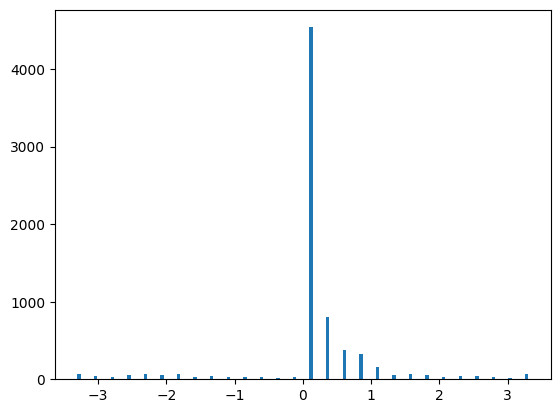

In [14]:
import numpy as np
import matplotlib.pyplot as plt
#@title Select the number of histogram bins

num_bins = 28 #@param {type:"slider", min:5, max:50, step:1}

hist, bins = np.histogram(df['angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
#plt.plot((np.min(df['angle']), np.max(df['angle'])), (samples_per_bin, samples_per_bin))

removed: 8923
remaining: 1773


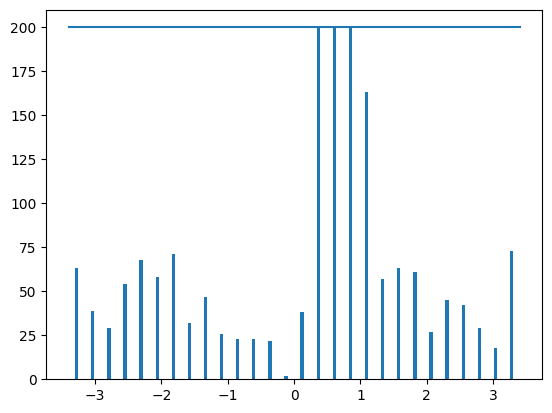

In [15]:
# Normalize the histogram (150-300 for RBG)
#@title Normalize the Histogram { run: "auto" }
hist = True #@param {type:"boolean"}

remove_list = []
samples_per_bin = 200

if hist:
  for j in range(num_bins):
    list_ = []
    for i in range(len(df['angle'])):
      if df.loc[i,'angle'] >= bins[j] and df.loc[i,'angle'] <= bins[j+1]:
        list_.append(i)
    random.shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

  print('removed:', len(remove_list))
  df.drop(df.index[remove_list], inplace=True)
  df.reset_index(inplace=True)
  df.drop(['index'],axis=1,inplace=True)
  print('remaining:', len(df))
  
  hist, _ = np.histogram(df['angle'], (num_bins))
  plt.bar(center, hist, width=0.05)
  plt.plot((np.min(df['angle']), np.max(df['angle'])), (samples_per_bin, samples_per_bin))

## View a Sample Image

C:/Users/master/Desktop/study/label_data/RC/center/1674635147334106922.jpg


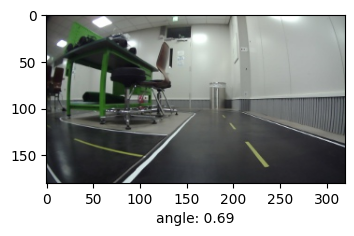

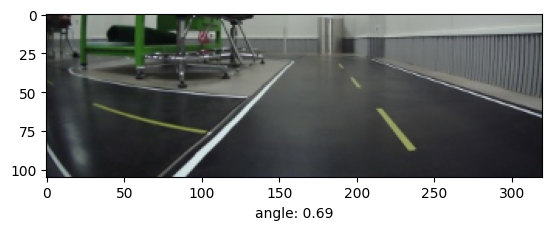

In [16]:
# View a Single Image 
index = random.randint(0,df.shape[0]-1)

img_name = data_set + '/' + df.loc[index,'filename']
print(img_name)
angle = df.loc[index,'angle']

center_image = cv2.imread(img_name)
center_image_mod = cv2.resize(center_image, (320,180))
center_image_mod = cv2.cvtColor(center_image_mod,cv2.COLOR_RGB2BGR)
#center_image_mod = cv2.cvtColor(center_image,cv2.COLOR_RGB2BGR)

# Crop the image
height_min = 75 
height_max = center_image_mod.shape[0]
width_min = 0
width_max = center_image_mod.shape[1]

crop_img = center_image_mod[height_min:height_max, width_min:width_max]

plt.subplot(2,1,1)
plt.imshow(center_image_mod)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(angle))
plt.show() 

plt.subplot(2,1,2)
plt.imshow(crop_img)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(angle))
plt.show() 

## View Multiple Images

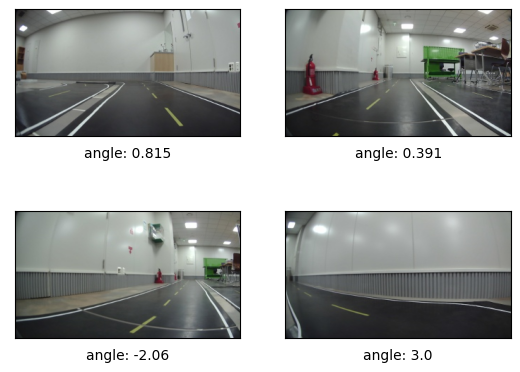

In [17]:
# Number of Images to Display
num_images = 4

# Display the images
i = 0
for i in range (i,num_images):
    index = random.randint(0,df.shape[0]-1)
    image_path = df.loc[index,'filename']
    angle = df.loc[index,'angle']
    img_name = data_set + '/' + image_path
    image = cv2.imread(img_name)
    image = cv2.resize(image, (320,180))
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    plt.subplot(int(num_images/2),int(num_images/2),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel('angle: {:.3}'.format(angle))
    i += 1

# Split the Dataset

## Define an ImageDataGenerator to Augment Images

[Exploring Image Data Augmentation with Keras and Tensorflow](https://towardsdatascience.com/exploring-image-data-augmentation-with-eras-and-tensorflow-a8162d89b844
)



In [18]:
# Create image data augmentation generator and choose augmentation types
datagen = ImageDataGenerator(
                             #rotation_range=20,
                             zoom_range=0.15,
                             #width_shift_range=0.1,
                             #height_shift_range=0.2,
                             #shear_range=10,
                             brightness_range=[0.5,1.0],
                          	 #horizontal_flip=True,
                             #vertical_flip=True,
                             #channel_shift_range=100.0,
                             fill_mode="reflect")

## View Image Augmentation Examples

Augmenting a Single Image: 



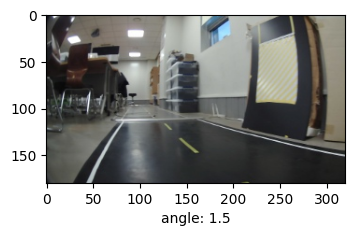

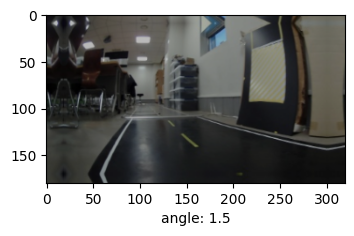

Multiple Augmentations: 



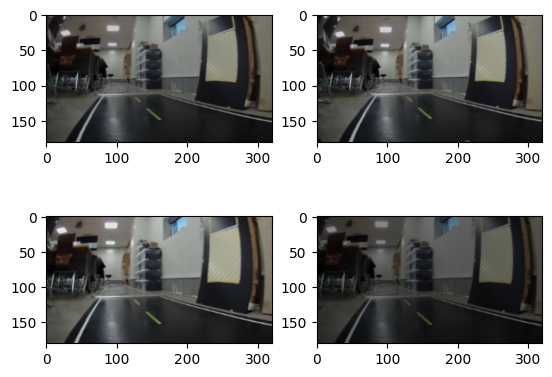

In [19]:
# load the image
index = random.randint(0,df.shape[0]-1)

img_name = data_set + '/' + df.loc[index,'filename']
original_image = cv2.imread(img_name)
original_image = cv2.cvtColor(original_image,cv2.COLOR_RGB2BGR)
original_image = cv2.resize(original_image, (320,180))
label = df.loc[index,'angle']

# convert to numpy array
data = img_to_array(original_image)

# expand dimension to one sample
test = expand_dims(data, 0)

# prepare iterator
it = datagen.flow(test, batch_size=1)

# generate batch of images
batch = it.next()

# convert to unsigned integers for viewing
image_aug = batch[0].astype('uint8')

print("Augmenting a Single Image: \n")

plt.subplot(2,1,1)
plt.imshow(original_image)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(label))
plt.show() 

plt.subplot(2,1,2)
plt.imshow(image_aug)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(label))
plt.show() 

print("Multiple Augmentations: \n")
# generate samples and plot
for i in range(0,num_images):
	# define subplot
	plt.subplot(int(num_images/2),int(num_images/2),i+1)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()


## Define a Data Generator

In [20]:
def generator(samples, batch_size=32, aug=0):
    num_samples = len(samples)

    while 1:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            #print(batch_samples)
            images = []
            angles = []
            for batch_sample in batch_samples:
                if batch_sample[5] != "filename":
                    name = data_set + '/' + batch_sample[3]
                    center_image = cv2.imread(name)
                    center_image = cv2.cvtColor(center_image,cv2.COLOR_RGB2BGR)
                    center_image = cv2.resize(
                        center_image,
                        (320,180))  #resize from 720x1280 to 180x320
                    angle = float(batch_sample[4])
                    if not aug:
                      images.append(center_image)
                      angles.append(angle)
                    else:
                        data = img_to_array(center_image)
                        sample = expand_dims(data, 0)
                        it = datagen.flow(sample, batch_size=1)
                        batch = it.next()
                        image_aug = batch[0].astype('uint8')
                        if random.random() < .5:
                          image_aug = np.fliplr(image_aug)
                          angle = -1 * angle
                        images.append(image_aug)
                        angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)

            yield sklearn.utils.shuffle(X_train, y_train)

## Split the Dataset

In [21]:
samples = []

samples = df.values.tolist()

sklearn.utils.shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print("Number of traing samples: ", len(train_samples))
print("Number of validation samples: ", len(validation_samples))

Number of traing samples:  1418
Number of validation samples:  355


## Define Training and Validation Data Generators

In [22]:
batch_size_value = 32
img_aug = 0

train_generator = generator(train_samples, batch_size=batch_size_value, aug=img_aug)
validation_generator = generator(
    validation_samples, batch_size=batch_size_value, aug=0)

# Compile and Train the Model

## Build the Model

In [23]:
# Initialize the model
model = Sequential()

# trim image to only see section with road
# (top_crop, bottom_crop), (left_crop, right_crop)
model.add(Cropping2D(cropping=((height_min,0), (width_min,0)), input_shape=(180,320,3)))

# Preprocess incoming data, centered around zero with small standard deviation
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

# Nvidia model
model.add(Convolution2D(24, (5, 5), activation="relu", name="conv_1", strides=(2, 2)))
# """"""
model.add(Convolution2D(36, (5, 5), activation="relu", name="conv_2", strides=(2, 2)))
model.add(Convolution2D(48, (5, 5), activation="relu", name="conv_3", strides=(2, 2)))
model.add(SpatialDropout2D(.5, dim_ordering='default'))

model.add(Convolution2D(64, (3, 3), activation="relu", name="conv_4", strides=(1, 1)))
model.add(Convolution2D(64, (3, 3), activation="relu", name="conv_5", strides=(1, 1)))

model.add(Flatten())

model.add(Dense(1164))
model.add(Dropout(.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mse','mae','mape','cosine'])

# Print model sumamry
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 105, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 105, 320, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 51, 158, 24)       1824      
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 77, 36)        21636     
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 37, 48)        43248     
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 10, 37, 48)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 8, 35, 64)        

c:\Users\master\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `SpatialDropout2D` call to the Keras 2 API: `SpatialDropout2D(0.5, data_format=None)`
  


## Setup Checkpoints

In [24]:
# checkpoint
model_path = 'C:/Users/master/Desktop/study/label_data/RC/model'

#!if [ -d $model_path ]; then echo 'Directory Exists'; else mkdir $model_path; fi

filepath = model_path + "/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

## Setup Early Stopping to Prevent Overfitting

In [25]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=10)

## Reduce Learning Rate When a Metric has Stopped Improving

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

## Setup Tensorboard

[Tensorboard Documentation](https://keras.io/callbacks/#tensorboard)

In [27]:
# Clear any logs from previous runs
#!rm -rf ./Graph/ 


# Launch Tensorboard
#!pip install -U tensorboardcolab
# from tensorflow.keras.callbacks import tensorboard
# from tensorboardcolab import *
from keras.callbacks import TensorBoard
# from tensorboard import *
tbc = TensorBoard()

# Configure the Tensorboard Callback
tbCallBack = TensorBoard(log_dir='./Graph', 
                        histogram_freq=1,
                        write_graph=True,
                        write_grads=True,
                        write_images=True,
                        batch_size=batch_size_value,
                        update_freq='epoch')


## Load Existing Model

In [28]:
load = False #@param {type:"boolean"}

if load:
  # Returns a compiled model identical to the previous one
  #!curl -O https://selbystorage.s3-us-west-2.amazonaws.com/research/office_2/model.h5
  #!mv model.h5 model/
  #model_path_full = model_path + '/' + 'model.h5'
  model_path_full = 'RC_gt_2.h5'
  model = load_model(model_path_full)
  print("Loaded previous model: {} \n".format(model_path_full))
else:
  print("No previous model loaded \n")

No previous model loaded 



In [29]:
STEP_SIZE_TRAIN = (len(train_samples) / batch_size_value)
STEP_SIZE_VALID = (len(validation_samples) / batch_size_value)


In [30]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


## Train the Model

In [31]:
# Define step sizes
STEP_SIZE_TRAIN = (len(train_samples) / batch_size_value)
STEP_SIZE_VALID = (len(validation_samples) / batch_size_value)

# Define number of epochs
n_epoch = 100 

# Define callbacks
# callbacks_list = [TensorBoardColabCallback(tbc)]
# callbacks_list = [TensorBoardColabCallback(tbc), early_stop]
# callbacks_list = [TensorBoardColabCallback(tbc), early_stop, checkpoint]
callbacks_list = [TensorBoard(tbc), early_stop, checkpoint, reduce_lr]

# Fit the model
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)
        
history_object = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    #callbacks=callbacks_list,
    use_multiprocessing=False,
    epochs=n_epoch) 


Epoch 1/100
45/44 [==============================] - 43s 954ms/step - loss: 3.1608 - mean_squared_error: 3.1608 - mean_absolute_error: 1.4804 - mean_absolute_percentage_error: 374337.4278 - cosine_proximity: -0.2239 - val_loss: 2.8623 - val_mean_squared_error: 2.8623 - val_mean_absolute_error: 1.3984 - val_mean_absolute_percentage_error: 118019.2065 - val_cosine_proximity: -0.4113
Epoch 2/100
45/44 [==============================] - 28s 619ms/step - loss: 2.7997 - mean_squared_error: 2.7997 - mean_absolute_error: 1.3673 - mean_absolute_percentage_error: 1077210.0270 - cosine_proximity: -0.4186 - val_loss: 0.8940 - val_mean_squared_error: 0.8940 - val_mean_absolute_error: 0.7234 - val_mean_absolute_percentage_error: 23215.5271 - val_cosine_proximity: -0.9070
Epoch 3/100
45/44 [==============================] - 27s 610ms/step - loss: 1.9730 - mean_squared_error: 1.9730 - mean_absolute_error: 1.0850 - mean_absolute_percentage_error: 1134594.9187 - cosine_proximity: -0.7275 - val_loss: 0.8

 ## Save the Model

In [32]:
# Save model
model_path_full = model_path + '/'

model.save(model_path_full + 'RC_gt_2.h5')
with open(model_path_full + 'RC_gt_2.json', 'w') as output_json:
    output_json.write(model.to_json())

# Evaluate the Model

## Plot the Training Results

Generating loss chart...
Done.


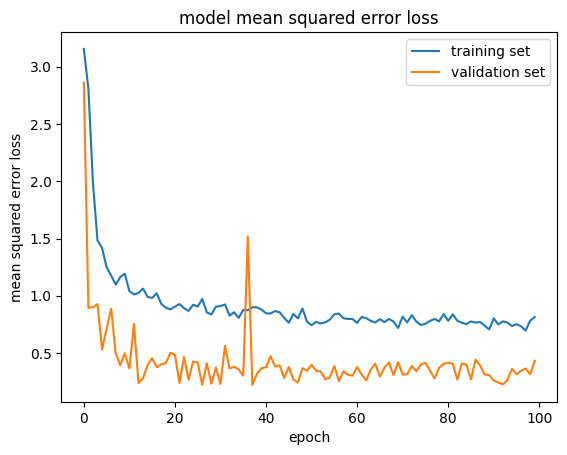

In [33]:
# Plot the training and validation loss for each epoch
print('Generating loss chart...')
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig(model_path_full + 'RC_gt_2_loss.png')

# Done
print('Done.')

## Print Performance Metrics

In [34]:
scores = model.evaluate_generator(validation_generator, STEP_SIZE_VALID, use_multiprocessing=False)

metrics_names = model.metrics_names

for i in range(len(model.metrics_names)):
  print(("Metric: {} - {}").format(metrics_names[i],scores[i]))


Metric: loss - 0.431604150063555
Metric: mean_squared_error - 0.431604150063555
Metric: mean_absolute_error - 0.4992387232646136
Metric: mean_absolute_percentage_error - 986330.9487648978
Metric: cosine_proximity - -0.9971830985915493


## Compute Prediction Statistics

200/200 [==============================] - 1s 3ms/step
[INFO] mean: 370.28%, std: 4614.37%
count    200.000000
mean      -0.072739
std        0.666047
min       -2.236854
25%       -0.446679
50%       -0.129470
75%        0.335222
max        1.595308
dtype: float64


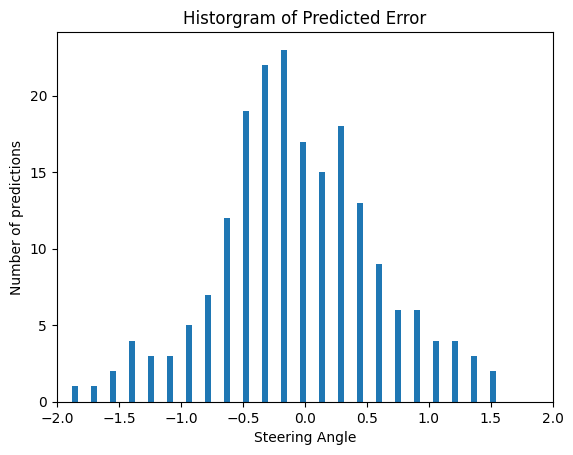

In [35]:
# Define image loading function
def load_images(dataframe):
  
  # initialize images array
  images = []
  
  for i in dataframe.index.values:
    name = data_set + '/' + dataframe.loc[i,'filename']
    center_image = cv2.imread(name)
    center_image = cv2.resize(center_image, (320,180))
    images.append(center_image)
    
  return np.array(images)
  
# Load images 
test_size = 200
df_test = df.sample(frac=1).reset_index(drop=True)
df_test = df_test.head(test_size)

test_images = load_images(df_test)

batch_size = 32
preds = model.predict(test_images, batch_size=batch_size, verbose=1)

#print("Preds: {} \n".format(preds))

testY = df_test.iloc[:,4].values

#print("Labels: {} \n".format(testY))

df_testY = pd.Series(testY)
df_preds = pd.Series(preds.flatten)

# Replace 0 angle values
if df_testY.eq(0).any():
  df_testY.replace(0, 0.0001,inplace=True)

# Calculate the difference
diff = preds.flatten() - df_testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

# Compute the mean and standard deviation of the difference
print(diff.describe())

# Plot a histogram of the prediction errors
num_bins = 25
hist, bins = np.histogram(diff, num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.title('Historgram of Predicted Error')
plt.xlabel('Steering Angle')
plt.ylabel('Number of predictions')
plt.xlim(-2.0, 2.0)
plt.plot(np.min(diff), np.max(diff))

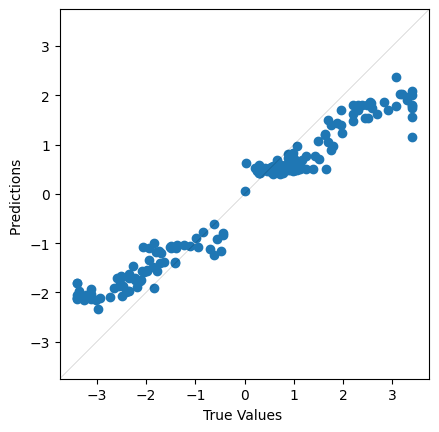

In [36]:
# Plot a Scatter Plot of the Error
plt.scatter(testY, preds)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([-3.75,3.75])
plt.ylim([-3.75,3.75])
plt.plot([-3.75, 3.75], [-3.75, 3.75], color='k', linestyle='-', linewidth=.1)
plt.savefig(model_path_full + 'RC_gt_2_prediction.png')

## Plot a Prediction

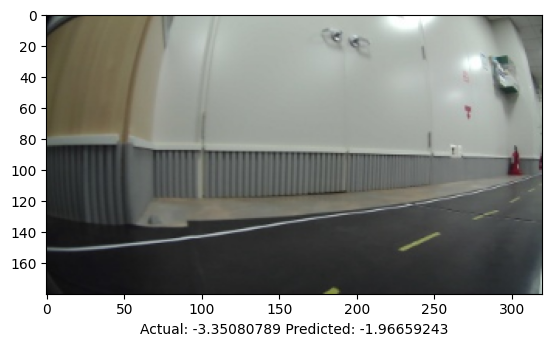

In [37]:
# Plot the image with the actual and predicted steering angle
index = random.randint(0,df_test.shape[0]-1)
img_name = data_set + '/' + df_test.loc[index,'filename']
center_image = cv2.imread(img_name)
center_image = cv2.cvtColor(center_image,cv2.COLOR_RGB2BGR)
center_image_mod = cv2.resize(center_image, (320,180)) #resize from 720x1280 to 180x320
plt.imshow(center_image_mod)
plt.grid(False)
plt.xlabel('Actual: {:.8f} Predicted: {:.8f}'.format(df_test.loc[index,'angle'],float(preds[index])))
plt.show() 


#Visualize the Network
https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/

##Show the Model Summary

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 105, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 105, 320, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 51, 158, 24)       1824      
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 77, 36)        21636     
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 37, 48)        43248     
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 10, 37, 48)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 8, 35, 64)        

##Access Individual Layers

In [39]:
# Creating a mapping of layer name ot layer details 
# We will create a dictionary layers_info which maps a layer name to its charcteristics
layers_info = {}
for i in model.layers:
    layers_info[i.name] = i.get_config()

#here the layer_weights dictionary will map every layer_name to its corresponding weights
layer_weights = {}
for i in model.layers:
    layer_weights[i.name] = i.get_weights()

pprint.pprint(layers_info['conv_5'])

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'dtype': 'float32',
 'filters': 64,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
                        'config': {'distribution': 'uniform',
                                   'mode': 'fan_avg',
                                   'scale': 1.0,
                                   'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (3, 3),
 'name': 'conv_5',
 'padding': 'valid',
 'strides': (1, 1),
 'trainable': True,
 'use_bias': True}


##Visualize the filters

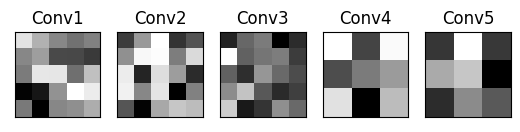

In [40]:
# Visualize the first filter of each convolution layer
layers = model.layers
layer_ids = [2,3,4,6,7]

#plot the filters
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(layers[layer_ids[i]].get_weights()[0][:,:,:,0][:,:,0],cmap='gray')
    ax[i].set_title('Conv'+str(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

##Visualize the Saliency Map

https://colab.research.google.com/github/idealo/cnn-exposed/blob/master/notebooks/Attribution.ipynb#scrollTo=jqSOW0pQniCw

https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/

https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb

In [41]:
# !pip install -I scipy==1.2
#pip install git+https://github.com/raghakot/keras-vis.git -U

#import specific functions from keras-vis package
from vis.utils import utils
from vis.visualization import visualize_saliency, visualize_cam, overlay
# from keras.models import load_model
# import keras
# import random
# import pandas as pd
# import cv2
# #import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf

# # Assume that you have 12GB of GPU memory and want to allocate ~4GB:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# print('############## Allowing Growth ###########')
# session = tf.Session(config=config)

# # -------------------  start importing keras module ---------------------
# import keras.backend.tensorflow_backend as K
# from keras.backend.tensorflow_backend import set_session
# set_session(tf.Session(config=config))


In [42]:
load = True #@param {type:"boolean"}

if load:
  # Returns a compiled model identical to the previous one
  #!curl -O https://selbystorage.s3-us-west-2.amazonaws.com/research/office_2/model.h5
  #!mv model.h5 model/
  #model_path_full = model_path + '/' + 'model.h5'
 
  model_path_full = 'C:/Users/master/Desktop/study/label_data/RC/model/RC_gt_2.h5'
  model = load_model(model_path_full)
  

  print("Loaded previous model: {} \n".format(model_path_full))
else:
  print("No previous model loaded \n")




Loaded previous model: C:/Users/master/Desktop/study/label_data/RC/model/RC_gt_100.h5 



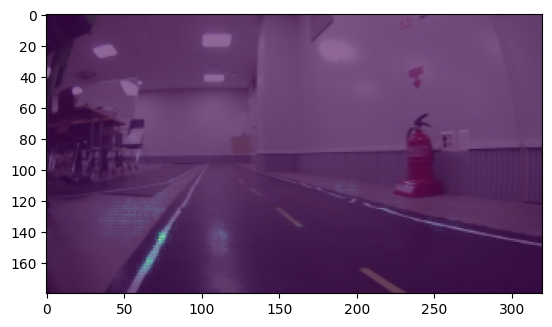

In [43]:
# View a Single Image 
#data_set = 'C:/Users/user/Desktop/Colab_RC/white_in'
#csv_path = 'C:/Users/user/Desktop/Colab_RC/white_in/interpolated.csv'
#df = pd.read_csv(csv_path, sep=",")



for i in range(5):
    index = random.randint(0,df.shape[0]-1)
    img_name = data_set + '/' + df.loc[index,'filename']
    #print(img_name)
    sample_image = cv2.imread(img_name)
    sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2BGR)
    sample_image_mod = cv2.resize(sample_image, (320,180)) #resize from 720x1280 to 180x320
    
    #plt.subplot(5,5,i+1)

    plt.imshow(sample_image_mod)

    layer_idx = utils.find_layer_idx(model, 'conv_5')

    grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=sample_image_mod, backprop_modifier='guided')

    plt.imshow(grads, alpha = 0.6)
plt.savefig('RC_gt_2_hitmap_1.png')


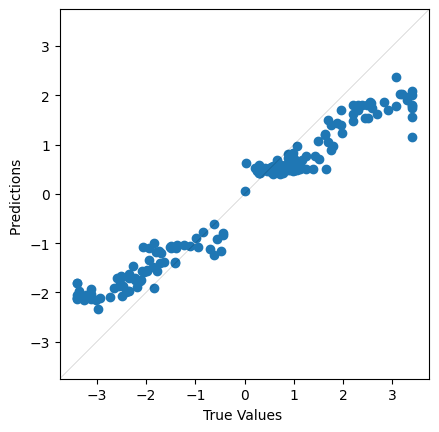

In [44]:
plt.scatter(testY, preds)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([-3.75,3.75])
plt.ylim([-3.75,3.75])
plt.plot([-3.75, 3.75], [-3.75, 3.75], color='k', linestyle='-', linewidth=.1)

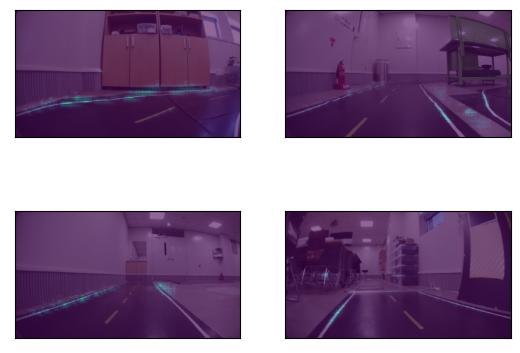

In [45]:
# View a Single Image 
# data_set = 'C:/Users/user/Desktop/Colab_RC/white_in'
# csv_path = 'C:/Users/user/Desktop/Colab_RC/white_in/interpolated.csv'
# df = pd.read_csv(csv_path, sep=",")

# Number of Images to Display
num_images = 4

# Display the images
i = 0
for i in range (i,num_images):
    index = random.randint(0,df.shape[0]-1)
    img_name = data_set + '/' + df.loc[index,'filename']
    sample_image = cv2.imread(img_name)
    sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2BGR)
    sample_image_mod = cv2.resize(sample_image, (320,180)) #resize from 720x1280 to 180x320
    plt.subplot(int(num_images/2),int(num_images/2),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_image_mod)
    layer_idx = utils.find_layer_idx(model, 'conv_5')
    grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=sample_image_mod, backprop_modifier='guided')
    plt.imshow(grads, alpha = 0.6)
    i += 1
plt.savefig('model/RC_gt_2_hitmap_2.png')

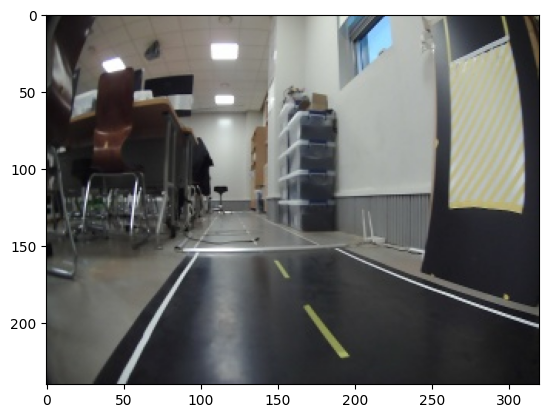

In [46]:
plt.imshow(sample_image)

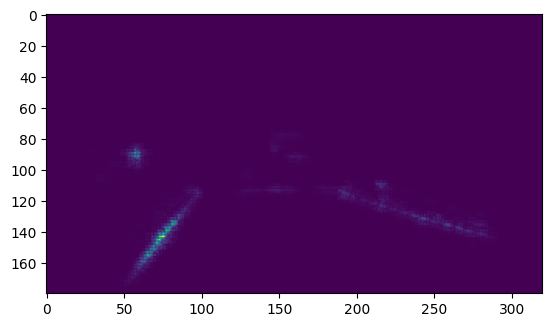

In [47]:
plt.imshow(grads)

# References:
https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/
https://www.pyimagesearch.com/2019/01/21/regression-with-keras/
https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb#scrollTo=7MqDQO0KCaWS

[Keras Image Processing Documentation](https://keras.io/preprocessing/image/)